# PETSc Time-stepping Solver -- Chemical Akzo Nobel Example

This example provides an overview of the PETSc time-stepping solver utilities in IDAES, which can be used to solve systems of differential algebraic equations (DAEs). PETSc is a solver suite developed primarily by Argonne National Lab (https://petsc.org/release/). IDAES provides a wrapper for PETSc (https://github.com/IDAES/idaes-ext/tree/main/petsc) that uses the AMPL solver interface (https://ampl.com/resources/learn-more/hooking-your-solver-to-ampl/) and utility functions that allow Pyomo and Pyomo.DAE (https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html) problems to be solved using PETSc.

This demonstration problem describes a set of chemical reactions in a reactor. A full description of the problem is available at https://archimede.dm.uniba.it/~testset/report/chemakzo.pdf. This is part of a test set which can be found at https://archimede.uniba.it/~testset/.

## Prerequisites

The PETSc solver is an extra download for IDAES.  The solver is available for Linux, but can be run in the Windows environment via the WSL (Windows Subsystem for Linux).  The WSL method of running the solver works smoothly in the normal Windows workflow.  PETSc installation details for Linux and Windows are available along with the documentation (https://idaes-pse.readthedocs.io/en/latest/technical_specs/core/solvers.html).

## Imports

Import the modules that will be used.  Numpy and matplotlib are used to make some plots, ```idaes.core.solvers.petsc``` contains the PETSc utilities, and ```idaes.core.solvers.features``` contains the example model used here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import idaes.core.solvers.petsc as petsc # petsc utilities module
from idaes.core.solvers.features import dae # DAE example/test problem

## Set Up the Model

The model in this example is used for basic solver testing, so it is provided as part of an IDAES solver testing module. The model implementation is standard Pyomo.DAE, and nothing special needs to be done in the model to use the PETSc solver.  The IDAES utilities for the PETSc solver will take the discretized Pyomo model and integrate between discrete time points to fill in the solution. To integrate over the entire time domain (as we will do here), you can discretize time using one time element, in which case, the problem will just contain the initial and final points.  The intermediate solutions can be read from the trajectory data saved by the solver.  The trajectory data can be used for analysis, or interpolation can be used to initialize a Pyomo problem before solving the fully time discretized problem.  Integrating over the entire time domain is fastest with a coarsely discretized model (ideally just a single finite element in time) because the model is smaller and there are fewer calls to the integrator.  This can be a good way to start testing a new dynamic IDAES model.

In [2]:
# To see the example problem code, uncomment the line below and execute this cell.
#??dae

In [3]:
# Get the model and known solution for y variables at t=180 minutes.
m, y1, y2, y3, y4, y5, y6 = dae(nfe=10)

The variables y1 to y6 represent concentrations of chemical species.  The values returned by the function above are the correct solution at t = 180.  These values can be used to verify the solver results.  The Pyomo model is ``m``.  We are mainly interested in the y variables.  The variables y1 to y5 are differential variables and y6 is an algebraic variable.  Initial conditions are required for y1 through y5, and the initial values of the other variables can be calculated from there.  The variables y1 through y5 at t = 0 are: ``m.y[0, 1]`` to ``m.y[0, 5]`` and y6 is ``m.y6[0]``.  The variables at the final state are ``m.y[180, 1]`` to ``m.y[180, 5]`` and ``m.y6[180]``.  The variable y6 is indexed differently because we want to treat it differently than the differential variables.

In [4]:
# See the initial conditions:
print("at t = 0:")
print(f"    y1 = {pyo.value(m.y[0, 1])}")
print(f"    y2 = {pyo.value(m.y[0, 2])}")
print(f"    y3 = {pyo.value(m.y[0, 3])}")
print(f"    y4 = {pyo.value(m.y[0, 4])}")
print(f"    y5 = {pyo.value(m.y[0, 5])}")

at t = 0:
    y1 = 0.444
    y2 = 0.00123
    y3 = 0.0
    y4 = 0.007
    y5 = 0.0


## Solve

The ``petsc_dae_by_time_element()`` function is used to solve Pyomo.DAE discretized Pyomo problem with the PETSc time-stepping solver by integrating between discrete time points.  In this case there is only one time element.

In [5]:
# To see the docs, uncomment the line below and execute this cell.
#?petsc.petsc_dae_by_time_element

In [6]:
# The command below will solve the problem.  In this case, we want to read the saved 
# trajectory for each time element in the Pyomo.DAE problem (in this case there is
# only 1) so we will need to provide solver options to save the trajectory to the PETSc
# solver, a file name stub for variable information files, and a file stub for saving 
# the trajectory information.  The options shown below will delete the trajectory
# information written by PETSc and resave it as json.  This allows us to cleanly read
# the trajectory data for multiple time elements.

result = petsc.petsc_dae_by_time_element(
    m,
    time=m.t,
    between=[m.t.first(), m.t.last()],
    ts_options={
        "--ts_type":"cn", # Crank–Nicolson
        "--ts_adapt_type":"basic",
        "--ts_dt":0.01,
        "--ts_save_trajectory":1,
    },
)
tj = result.trajectory
res = result.results

2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: DAE: 0
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\EslickJ\AppData\Local\Temp\tmpseulgqn9.pyomo.nl
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of constraints: 12
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 1
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 11
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of variables: 12
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2022-04-20 15:44:06 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2022-04-20 

In [7]:
#Verify results
assert abs(y1 - pyo.value(m.y[180, 1]))/y1 < 1e-3
assert abs(y2 - pyo.value(m.y[180, 2]))/y2 < 1e-3 
assert abs(y3 - pyo.value(m.y[180, 3]))/y3 < 1e-3 
assert abs(y4 - pyo.value(m.y[180, 4]))/y4 < 1e-3 
assert abs(y5 - pyo.value(m.y[180, 5]))/y5 < 1e-3
assert abs(y6 - pyo.value(m.y6[180]))/y6 < 1e-3 

## Plot Results Stored in Model

In the problem above we used the PETSc to integrate between the first and last time point.  By default, the PETSc DAE utility will interpolate from the PETSc trajectory to fill in the skipped points.

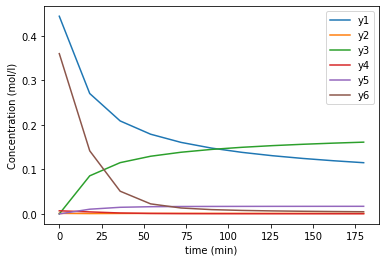

In [8]:
a = plt.plot(m.t, [pyo.value(m.y[t, 1]) for t in m.t], label="y1")
a = plt.plot(m.t, [pyo.value(m.y[t, 2]) for t in m.t], label="y2")
a = plt.plot(m.t, [pyo.value(m.y[t, 3]) for t in m.t], label="y3")
a = plt.plot(m.t, [pyo.value(m.y[t, 4]) for t in m.t], label="y4")
a = plt.plot(m.t, [pyo.value(m.y[t, 5]) for t in m.t], label="y5")
a = plt.plot(m.t, [pyo.value(m.y6[t]) for t in m.t], label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

## Plot Trajectory

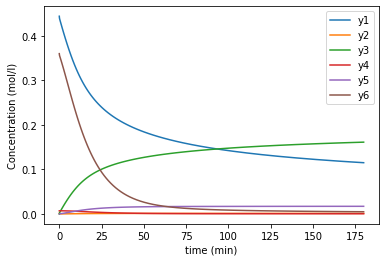

In [9]:
# First plot all y's on one plot

a = plt.plot(tj.time, tj.get_vec(m.y[180, 1]), label="y1")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 3]), label="y3")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 4]), label="y4")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 5]), label="y5")
a = plt.plot(tj.time, tj.get_vec(m.y6[180]), label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

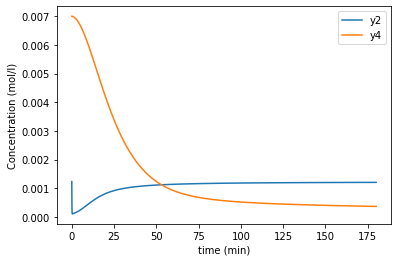

In [10]:
# 2 and 4 are pretty low concentration, so plot those so we can see better
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 4]), label="y4")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

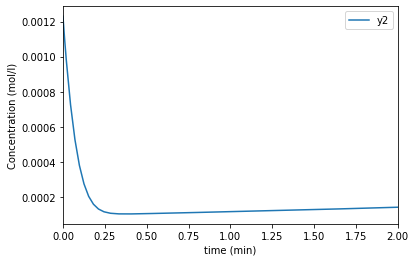

In [11]:
# 2 seems to have some fast dynamics so plot a shorter time
a = plt.plot(tj.vecs["_time"], tj.vecs[str(m.y[180, 2])], label="y2")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")
a = plt.xlim(0, 2)

## Interpolate Trajectory

For a number of reasons, such as initializating Pyomo problems or showing results at even time intervals it can be useful to show values at specific time points.  The PetscTrajectory class has a method to use linear interpolation to produce a new dictionary of trajectory data at specified time points. 

In [12]:
# This creates a new trajectory data set with data every minute.
tji = tj.interpolate(np.linspace(0, 180, 181))

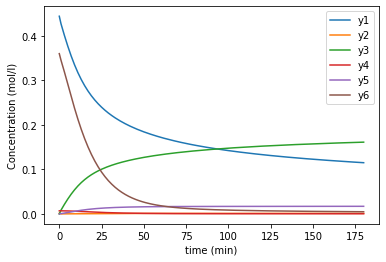

In [13]:
# The plot of this new data should look the same as the original, although some of the 
# fast dynamics of component 2 will be obscured.

a = plt.plot(tji.time, tji.get_vec(m.y[180, 1]), label="y1")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 2]), label="y2")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 3]), label="y3")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 4]), label="y4")
a = plt.plot(tji.time, tji.get_vec(m.y[180, 5]), label="y5")
a = plt.plot(tji.time, tji.get_vec(m.y6[180]), label="y6")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")

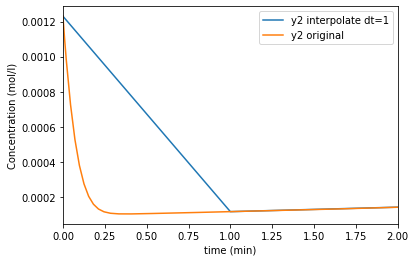

In [14]:
a = plt.plot(tji.time, tji.get_vec(m.y[180, 2]), label="y2 interpolate dt=1")
a = plt.plot(tj.time, tj.get_vec(m.y[180, 2]), label="y2 original")
a = plt.legend()
a = plt.ylabel("Concentration (mol/l)")
a = plt.xlabel("time (min)")
a = plt.xlim(0, 2)